### PyTorch Setup

In [1]:
# Check for GPU availability
import tensorflow as tf
print('Device name: ', tf.test.gpu_device_name())

# Install pytorch and libraries
!pip install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl && pip install -q torchvision && pip install torchtext

# Import torch and libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchtext

# Check for GPU availability
use_gpu = torch.cuda.is_available()
# use_gpu = False
print()
print('Use GPU: ', use_gpu)
print()

Device name:  /device:GPU:0
    100% |████████████████████████████████| 51kB 1.8MB/s 
    100% |████████████████████████████████| 61kB 3.8MB/s 

Use GPU:  True



### VAE

#### Extend PyTorch with PyTorch 4.0 Features Manually

In [0]:
class NewNormal(torch.distributions.Normal):
    def __init__(self, loc, scale):
        super(NewNormal, self).__init__(loc, scale)
#         print()
    
    def rsample(self, sample_shape=torch.Size()):
        shape = self.mean.size() #self._extended_shape(sample_shape)
        eps = V(torch.zeros(shape).normal_().cuda(), requires_grad=True)
        return self.mean + eps * self.std

def kl_divergence(p, q):
    var_ratio = (p.std / q.std).pow(2)
    t1 = ((p.mean - q.mean) / q.std).pow(2)
    return 0.5 * (var_ratio + t1 - 1 - var_ratio.log())

#### Utils

In [0]:
import itertools, os, re

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import save_image
use_gpu = torch.cuda.is_available()

class Logger():
    '''Prints to a log file and to standard output''' 
    def __init__(self, path):
        if os.path.exists(path):
            self.path = path
        else:
            raise Exception('path does not exist')
    
    def log(self, info, stdout=True):
      with open(os.path.join(self.path, 'log.log'), 'a') as f:
        print(info, file=f)
      if stdout:
        print(info)
    
    def save_model(self, model_dict):
        torch.save(model_dict, os.path.join(self.path, 'model.pkl'))
        
    def save_image(self, imageTensor, filename='example.jpg'):
        save_image(imageTensor, os.path.join(self.path, filename))

class AverageMeter():
    '''Computes and stores the average and current value. 
       Taken from the PyTorch ImageNet tutorial'''
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
   
    def update(self, val, n=1):
        self.val = val
        self.sum = self.sum + val * n
        self.count = self.count + n
        self.avg = self.sum / self.count


#### Training

In [0]:
import itertools, os, sys, time
sys.path.append('../')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
# from torch.distributions import Normal
# from torch.distributions import kl
use_gpu = torch.cuda.is_available()

# from utils.utils import AverageMeter

def trainfile_train(train_loader, test_loader, model, optimizer, scheduler, num_epochs, logger=None):  
    batch_size = next(iter(train_loader))[1].nelement() # size of label = batch size
    
     # N(0, I) prior on latent variables
    p = prior(batch_size, model.dim_lat) 

    # Iterate through epochs
    loss_val_best = 100.0
    for epoch in range(num_epochs):
    
        # Validate model
        start_time = time.time() # timer 
        show_image = epoch % 5 == 0
        loss_val = trainfile_valid(test_loader, model, logger, show_image=show_image)
        if loss_val < loss_val_best:
            loss_val_best = loss_val 
            logger.save_model(model.state_dict())
            logger.log('New best: {:.3f}'.format(loss_val))
        val_time = time.time()
        logger.log('') #Validation time: {:.3f}\n'.format(val_time - start_time))

        # Step learning rate scheduler
        scheduler.step(loss_val) 

        # Train model
        model.train()
        t_losses = AverageMeter() # total loss
        r_losses = AverageMeter() # reconstruction loss
        k_losses = AverageMeter() # kl divergence loss
        for i, (x, y) in enumerate(train_loader): 
            b = y.nelement() # current batch size
            if b != batch_size: continue; # skip batch if too small
            x = V(x.cuda()) if use_gpu else V(x) # FloatTensor - images of size bs x 1 x 28 x 28
            y = V(y.cuda()) if use_gpu else V(y) # LongTensor - labels of size bs in range 0,1,...,9

            # Forward pass
            model.zero_grad()
            x_hat, q = model(x)
            
            ##################
            # print((q.mean, y))
            ##################
    
            # Calculate loss
            t_loss, r_loss, k_loss = loss_function(x, x_hat, p, q, alpha=1.0)
        
            # Record loss
            t_losses.update(t_loss.data[0] / b) # avg loss = total loss / batch size
            r_losses.update(r_loss.data[0] / b)
            k_losses.update(k_loss.data[0] / b)

            # Backward pass
            t_loss.backward()
            optimizer.step()

            # # Log during epoch
            # if i % 10000 == 10:
            #     logger.log('Epoch [{e}/{num_e}]\t Batch [{b}/{num_b}]\t Total Loss: {l:.3f}\tRecon Loss: {r:.3f}\tKL Loss: {k:.3f}'.format(e=epoch+1, num_e=num_epochs, b=i, num_b=len(train_loader), l=t_losses.avg, r=r_losses.avg, k=k_losses.avg))

        # Log after epoch
        logger.log('Epoch [{e}/{num_e}] complete.\tTotal Loss: {l:.3f}\tRecon Loss: {r:.3f}\tKL Loss: {k:.3f}\n'.format(e=epoch+1, num_e=num_epochs, l=t_losses.avg, r=r_losses.avg, k=k_losses.avg))

def trainfile_valid(val_loader, model, logger, show_image=False):
    model.eval() # evaluation mode
    batch_size = next(iter(val_loader))[1].nelement() # num elems in label = batch size

    # N(0, I) prior on latent variables
    p = prior(batch_size, model.dim_lat) 
    
    # Loop through validation set
    start_time = time.time() # timer 
    t_losses = AverageMeter() # total loss
    r_losses = AverageMeter() # reconstruction loss
    k_losses = AverageMeter() # kl divergence loss
    for i, (x, y) in enumerate(val_loader): 
        b = y.nelement() # current batch size
        if b != batch_size: continue; # skip batch if too small
        x = V(x.cuda()) if use_gpu else V(x) # FloatTensor - images of size bs x 1 x 28 x 28
        y = V(y.cuda()) if use_gpu else V(y) # LongTensor - labels of size bs in range 0,1,...,9

        # Forward, calculate loss 
        x_hat, q = model(x)
        t_loss, r_loss, k_loss = loss_function(x, x_hat, p, q, alpha=1.0)
        
        # Record loss
        t_losses.update(t_loss.data[0] / b) # avg loss = total loss / batch size
        r_losses.update(r_loss.data[0] / b)
        k_losses.update(k_loss.data[0] / b)
        
        # Visualize images 
        if i == 25 and show_image:
          print('ORIGINAL: ')
          visualize(x.data)
          print('RECONSTRUCTED: ')
          visualize(x_hat.data)
        

    logger.log('Validation complete.\tTotal loss: {:.3f}\tRecon Loss: {:.3f}\tKL Loss: {:.3f}'.format(t_losses.avg, r_losses.avg, k_losses.avg))
    return t_losses.avg
    
def prior(batch_size, dim_latent):
    '''Returns N(0, I) prior on latent variables'''
    mean_p = V(torch.zeros(batch_size, dim_latent)) 
    var_p = V(torch.ones(batch_size, dim_latent))
    if use_gpu: 
        mean_p = mean_p.cuda()
        var_p = var_p.cuda()
    return NewNormal(mean_p, var_p) 

def loss_function(x, x_hat, p, q, alpha=1.0):
    '''Total loss is sum of reconstruction and kl losses'''
    reconstruction_loss = F.mse_loss(x_hat, x, size_average=False)
    kl_divergence_loss = kl_divergence(q, p).sum()
    total_loss = reconstruction_loss + alpha * kl_divergence_loss
    return total_loss, reconstruction_loss, kl_divergence_loss

#### Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
use_gpu = torch.cuda.is_available()

# from torch.distributions import Normal
# from torch.distributions.kl import kl_divergence

class Encoder(nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, dp=0.2):
        '''Creates neural network for q_{phi(x)}(z)'''
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(dim_in, dim_h)
        self.linear2 = nn.Linear(dim_h, dim_h)
        self.linear_mean = nn.Linear(dim_h, dim_out)
        self.linear_logvar = nn.Linear(dim_h, dim_out) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dp)
        
    def forward(self, x):
        '''Returns mean, logvar vectors, each of size dim_out''' 
        x = self.relu(self.linear1(x))
        #x = self.dropout(x)
        x = self.relu(self.linear2(x))
        #x = self.dropout(x)
        mean = self.linear_mean(x)
        logvar = self.linear_logvar(x) 
        return mean, logvar 

class Decoder(nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, dp=0.2):
        super(Decoder, self).__init__()
        '''Creates neural network for p_{theta}(x|z)'''
        self.linear1 = nn.Linear(dim_in, dim_h)
        self.linear2 = nn.Linear(dim_h, dim_h)
        self.linear3 = nn.Linear(dim_h, dim_out)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dp)

    def forward(self, z):
        '''Returns output x of size dim_out given latent variable z''' 
        z = self.relu(self.linear1(z))
        #z = self.dropout(z)
        z = self.relu(self.linear2(z))
        #z = self.dropout(z)
        z = self.linear3(z)
        return z

class VAE(nn.Module):
    def __init__(self):
        '''Creates variational autoencoder'''
        super(VAE, self).__init__()
        self.dim_x = 28 * 28
        self.dim_lat = 2
        self.dim_h = 300
        self.dp = 0.0

        self.encoder = Encoder(self.dim_x, self.dim_h, self.dim_lat, dp=self.dp)
        self.decoder = Decoder(self.dim_lat, self.dim_h, self.dim_x, dp=self.dp)

    def forward(self, x):
        '''Returns reconstruction x_hat from x'''
        # Reshape x for linear layer
        x = x.view(-1, 28 * 28) # bs x 28*28
        # Obtain parameters of latent variable from q_{phi}(z)
        mean, logvar = self.encoder(x)
        # Construct normal distribution q_{phi}(z)
        q = NewNormal(loc=mean, scale=logvar.mul(0.5).exp())
        # Sample from normal to get latent variable z using reparam trick
        z = q.rsample()
        # Reconstruct x from latent variable z
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, 1, 28, 28) # bs x 1 x 28 x 28
        return x_hat, q

#### Main

Train batches: 782. Valid batches: 157. Batch size: 64.
ORIGINAL: 


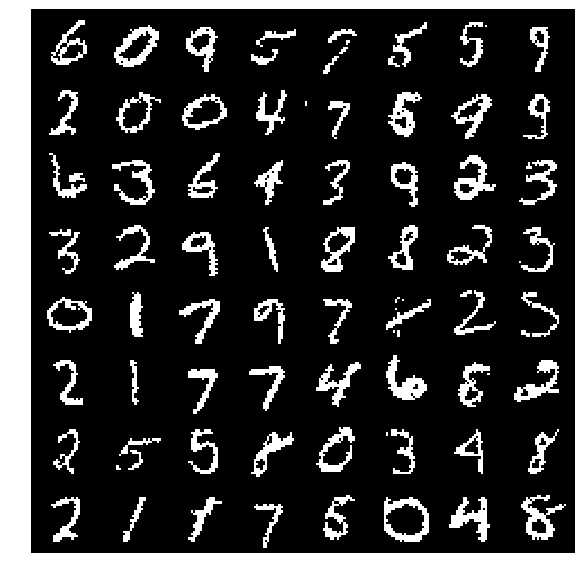

RECONSTRUCTED: 


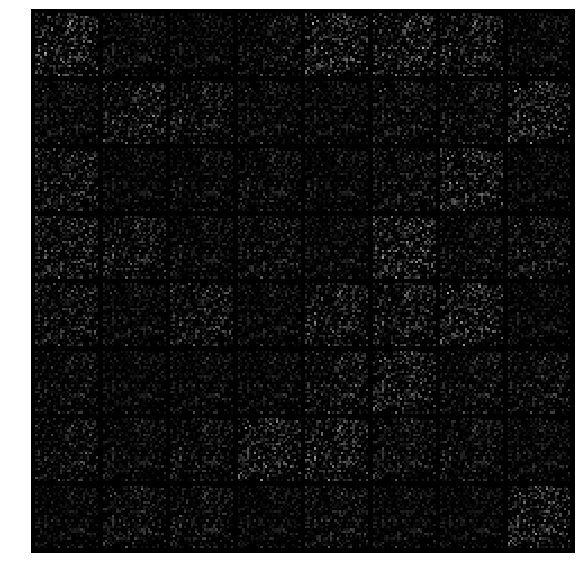

Validation complete.	Total loss: 113.260	Recon Loss: 113.259	KL Loss: 0.002

Epoch [1/100] complete.	Total Loss: 62.073	Recon Loss: 60.076	KL Loss: 1.997

Validation complete.	Total loss: 59.559	Recon Loss: 56.870	KL Loss: 2.689
New best: 59.559

Epoch [2/100] complete.	Total Loss: 57.159	Recon Loss: 53.718	KL Loss: 3.441

Validation complete.	Total loss: 54.322	Recon Loss: 50.331	KL Loss: 3.992
New best: 54.322

Epoch [3/100] complete.	Total Loss: 54.049	Recon Loss: 49.912	KL Loss: 4.137

Validation complete.	Total loss: 52.830	Recon Loss: 48.691	KL Loss: 4.139
New best: 52.830

Epoch [4/100] complete.	Total Loss: 52.948	Recon Loss: 48.546	KL Loss: 4.402

Validation complete.	Total loss: 51.879	Recon Loss: 47.365	KL Loss: 4.514
New best: 51.879

Epoch [5/100] complete.	Total Loss: 52.286	Recon Loss: 47.727	KL Loss: 4.558

ORIGINAL: 


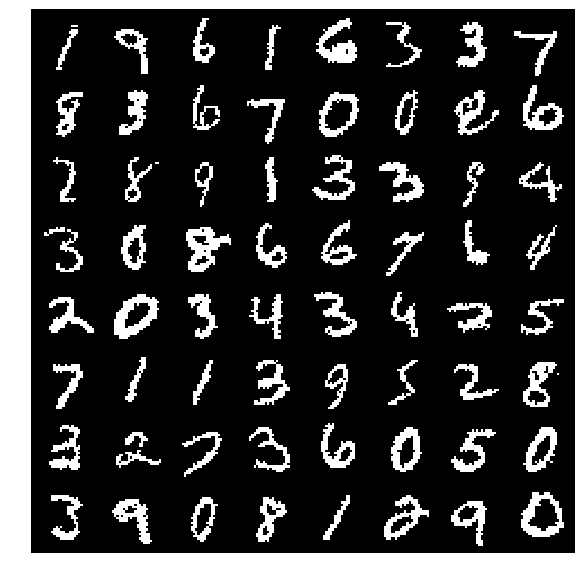

RECONSTRUCTED: 


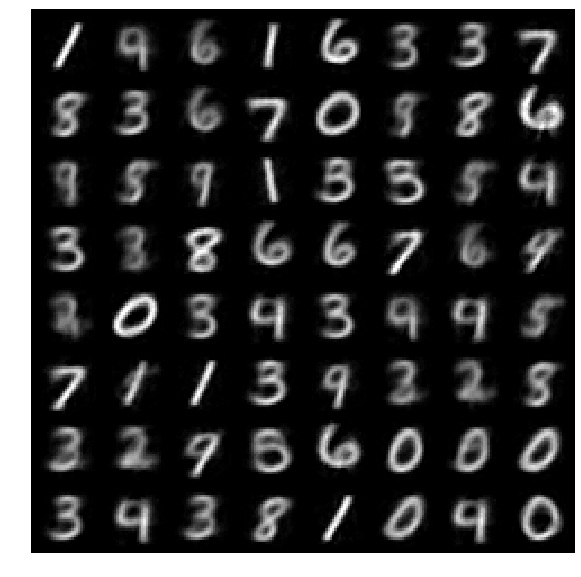

Validation complete.	Total loss: 51.784	Recon Loss: 47.205	KL Loss: 4.580
New best: 51.784

Epoch [6/100] complete.	Total Loss: 51.926	Recon Loss: 47.269	KL Loss: 4.657

Validation complete.	Total loss: 51.261	Recon Loss: 46.653	KL Loss: 4.607
New best: 51.261

Epoch [7/100] complete.	Total Loss: 51.642	Recon Loss: 46.904	KL Loss: 4.738

Validation complete.	Total loss: 51.124	Recon Loss: 46.321	KL Loss: 4.802
New best: 51.124

Epoch [8/100] complete.	Total Loss: 51.439	Recon Loss: 46.668	KL Loss: 4.771

Validation complete.	Total loss: 50.877	Recon Loss: 46.175	KL Loss: 4.702
New best: 50.877

Epoch [9/100] complete.	Total Loss: 51.170	Recon Loss: 46.351	KL Loss: 4.819



In [0]:
# Simulate argparse 
class Bunch:
    def __init__(self, **kwds):
        self.__dict__.update(kwds)
args = Bunch(dp=0.0, lr=2e-3, b=64, evaluate=False, model='saves/working_trained/model.pkl', epochs=100)

# main.py
import torch
import torch.nn as nn
from torch.autograd import Variable as V
from torchvision import datasets, transforms

# def main():
#     global args
#     args = parser.parse_args()
time_data = time.time()
use_gpu = torch.cuda.is_available()
torch.manual_seed(3435)

# Download and process data
train_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms  = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) 
test_dataset = datasets.MNIST('../data', train=False, transform=train_transforms) 

# Turn grayscale images to binary
train_images = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_labels = torch.LongTensor([d[1] for d in train_dataset])
test_images = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_labels = torch.LongTensor([d[1] for d in test_dataset])

# Create validation set from last 10000 training images
valid_images = train_images[-10000:].clone()
valid_labels = train_labels[-10000:].clone()
train_images = train_images[:-10000]
train_labels = train_labels[:-10000]

# Load datasets
train = torch.utils.data.TensorDataset(train_images, train_labels)
valid = torch.utils.data.TensorDataset(valid_images, valid_labels)
test  = torch.utils.data.TensorDataset(test_images, test_labels)

# Create dataloaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}
train_loader = torch.utils.data.DataLoader(train, batch_size=args.b, shuffle=True,  **kwargs)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.b, shuffle=True,  **kwargs)
test_loader  = torch.utils.data.DataLoader(test,  batch_size=args.b, shuffle=False, **kwargs) 
print('Train batches: {}. Valid batches: {}. Batch size: {}.'.format(len(train_loader), len(valid_loader), args.b))

# Create model (already configured for MNIST) and load pretrained
model = VAE()
if args.model is not None and os.path.isfile(args.model):
  model.load_state_dict(torch.load(args.model))
  print('Loaded pretrained model.')
model = model.cuda() if use_gpu else model

# Create loss function and optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=30, factor=0.25, verbose=True, cooldown=6)

# Create directory for logs, create logger, log hyperparameters
#path = os.path.join('saves', datetime.datetime.now().strftime("%m-%d-%H-%M-%S")) 
path = 'saves/working' 
os.makedirs(path, exist_ok=True)
logger = Logger(path)
logger.log('COMMAND: ' + ' '.join(sys.argv), stdout=False)
logger.log('ARGS: {}\nOPTIMIZER: {}\nLEARNING RATE: {}\nSCHEDULER: {}\nMODEL: {}\n'.format(args, optimizer, args.lr, vars(scheduler), model), stdout=False)

# Train, validate, or predict
start_time = time.time()
#if args.visualize:
#    visualize.visualize(train_iter, model, SRC, TRG, logger)
if args.evaluate:
    trainfile_valid(valid_loader, model, logger)
else:
    trainfile_train(train_loader, valid_loader, model, optimizer, scheduler, args.epochs, logger)

logger.log('Finished in {}'.format(time.time() - start_time))
# return

# main()

#### Visualization

In [0]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]


def visualize(x, save=False, logger=None, filename='', nrow=8):
    '''Displays or saves an image or grid of images from tensor'''
    if save:
        logger.save_image(x, filename=filename)
    else: 
        # get 1st img, convert to color, convert to numpy, clip to image range
        x = x.expand(x.size(0), 3, x.size(2), x.size(3))
        x = make_grid(x, nrow=nrow)
        x = x.cpu().numpy().transpose(1, 2, 0).clip(0, 1)
        plt.axis('off')
        plt.imshow(x)
        plt.show()
        

#### Interpolation

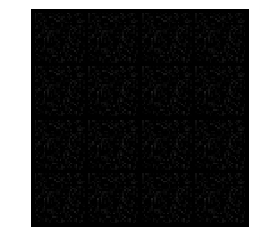

In [8]:
def interpolate_between_latents(x, y, num_images=16):
    '''Outputs linear interpolation between input tensors x and y'''
    zs = []
    for t in range(num_images):
        t = t / num_images
        z = x * t + y * (1 - t) # linear interp
        zs.append(z)
    zs = torch.stack(zs, dim=0)
    return zs
    
def get_two_latents(val_loader, model):
    '''Returns mean latent variables from two examples'''
    model.eval() # evaluation mode
    batch_size = next(iter(val_loader))[1].nelement() # num elems in label = batch size

    # N(0, I) prior on latent variables
    p = prior(batch_size, model.dim_lat) 

    for i, (x, y) in enumerate(val_loader): 
        b = y.nelement() # current batch size
        if b != batch_size: continue; # skip batch if too small
        x = V(x.cuda()) if use_gpu else V(x) # FloatTensor - images of size bs x 1 x 28 x 28

        # Forward, calculate loss
        x_hat, q = model(x)
        
        # Return mean of latents from first two images in batch
        return q.mean[0], q.mean[1]  

def decode_from_latent(model, z):
    '''Decode image from random latent variable'''
    z = model.decoder(z).view(-1, 1, 28, 28)
    visualize(z.data, nrow=4)

def decode_from_rann_latent(model):
    z = V(torch.randn(64, 12).cuda())
    decode_from_latent(model, z)

def decode_from_interpolation(val_loader, model):
    a, b = get_two_latents(valid_loader, model)
    zs = interpolate_between_latents(a, b)
    decode_from_latent(model, zs)
    
decode_from_interpolation(valid_loader, model)

#### Things to change
- Add variable around x.cuda() and y.cuda()


In [0]:
def get_lats():
  lats = torch.zeros(20, 20, 2)
  for i1 in range(-10,10):
      for i2 in range(-10, 10):
          lats[i1+10,i2+10] = torch.FloatTensor([i1, i2]) / 2
  return lats

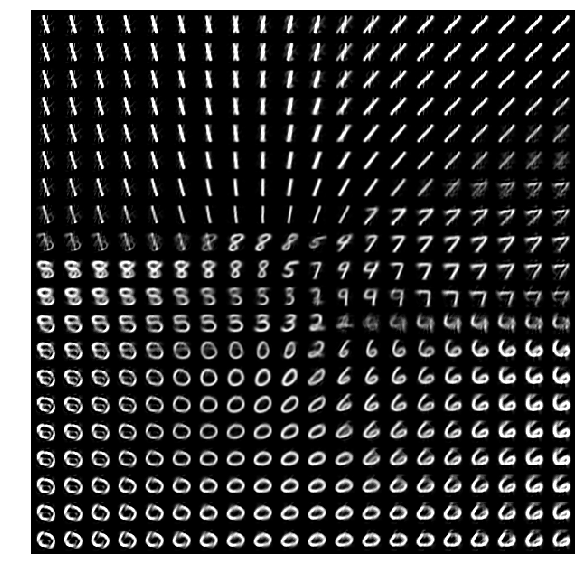

In [41]:
def get_vis():
  lats = V(get_lats()).cuda()
  z = model.decoder(lats).view(-1, 1, 28, 28)
  visualize(z.data, nrow=20)

get_vis()